/opt/homebrew/lib/python3.11/site-packages/pvlib/pvsystem.py:2463: pvlibDeprecationWarning: 
The pvlib.pvsystem.singlediode parameter ivcurve_pnts was deprecated in pvlib 0.10.0 and will be removed in 0.11.0. Use pvlib.pvsystem.v_from_i and pvlib.pvsystem.i_from_v instead.
  warn_deprecated('0.10.0', name='pvlib.pvsystem.singlediode',


                     Irradiance    V             I    P  PCE@GHI  P_CFPV
index_date                                                              
2022-01-01 00:00:00         0.0  0.0 -3.029226e-28 -0.0     20.0    -0.0
2022-01-01 00:01:00         0.0  0.0  0.000000e+00  0.0     20.0     0.0
2022-01-01 00:02:00         0.0  0.0  0.000000e+00  0.0     20.0     0.0
2022-01-01 00:03:00         0.0  0.0  0.000000e+00  0.0     20.0     0.0
2022-01-01 00:04:00         0.0  0.0  3.029226e-28  0.0     20.0     0.0
...                         ...  ...           ...  ...      ...     ...
2023-01-01 23:55:00         0.0  NaN           NaN  NaN     20.0     NaN
2023-01-01 23:56:00         0.0  NaN           NaN  NaN     20.0     NaN
2023-01-01 23:57:00         0.0  NaN           NaN  NaN     20.0     NaN
2023-01-01 23:58:00         0.0  NaN           NaN  NaN     20.0     NaN
2023-01-01 23:59:00         0.0  NaN           NaN  NaN     20.0     NaN

[527040 rows x 6 columns]


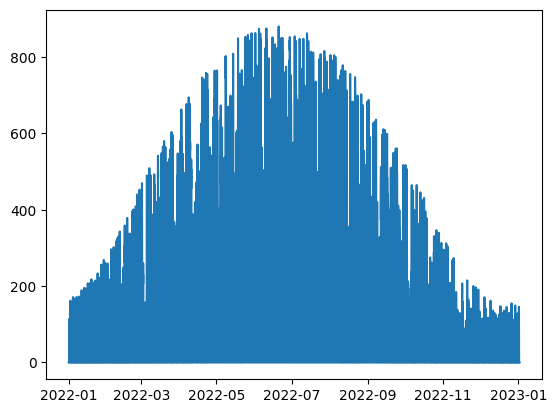

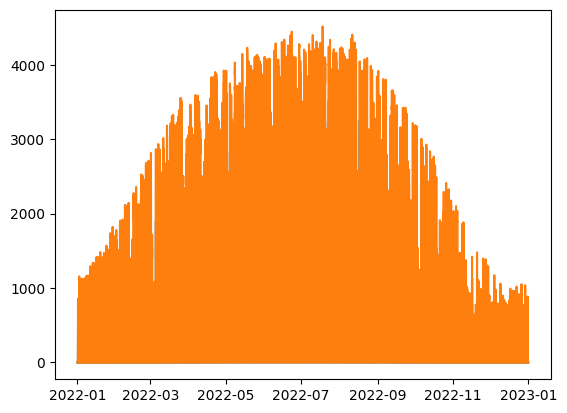

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pvlib import pvsystem
from datetime import datetime
from parameters_pv import parameters
# from utils.parameters_pv import parameters
import builtins

series_panel = 5
parallel_panel = 3 
#CFPV Data
PCE_ref_CFPV = 10
#y=mx+b
slope_2x_enhance = (-1/100)
constant_2x_enhance = 20
temperature_file = "/Users/alexisaglar/decentralised_network_analysis/data/meteorological_data/retrieved_data/temperature.csv"
irradiance_file = "/Users/alexisaglar/decentralised_network_analysis/data/meteorological_data/retrieved_data/irradiance.csv"

def get_csv_data(temperature_file, irradiance_file):
    with builtins.open(f'{temperature_file}', newline='') as temperature_data, open(f'{irradiance_file}', newline='') as irradiance_data:
        irradiance = pd.read_csv(irradiance_data)
        irradiance['index_date'] = pd.to_datetime(irradiance['index_date'])
        irradiance.set_index(irradiance['index_date'], inplace=True)
    
        temperature = pd.read_csv(temperature_data)
        temperature['valid_time'] = pd.to_datetime(temperature['valid_time'])
        temperature.set_index(temperature['valid_time'], inplace=True)

    # irradiance = irradiance.loc['2023-01-29']
    # temperature = temperature.loc['2023-01-29']
    return irradiance, temperature

def pv_generation(irradiance, temperature, series_panel, parallel_panel, PCE_ref_CFPV):
    IL, I0, Rs, Rsh, nNsVth = pvsystem.calcparams_desoto(
        irradiance['GHI'],
        temperature['t2m'],
        alpha_sc=parameters['alpha_sc'],
        a_ref=parameters['a_ref'],
        I_L_ref=parameters['I_L_ref'],
        I_o_ref=parameters['I_o_ref'],
        R_sh_ref=parameters['R_sh_ref'],
        R_s=parameters['R_s'],
        EgRef=1.121,
        dEgdT=-0.0002677
    )

    # plug the parameters into the SDE and solve for IV curves:
    curve_info = pvsystem.singlediode(
        photocurrent=IL,
        saturation_current=I0,
        resistance_series=Rs,
        resistance_shunt=Rsh,
        nNsVth=nNsVth,
        ivcurve_pnts=100,
        method='lambertw'
    )

    Cell_result = pd.DataFrame({
        'i_sc': curve_info['i_sc'],
        'v_oc': curve_info['v_oc'],
        'i_mp': curve_info['i_mp'],
        'v_mp': curve_info['v_mp'],
        'p_mp': curve_info['p_mp'],
    }).set_index(irradiance.index)

    Total_PV = pd.DataFrame({
        'Irradiance': irradiance['GHI'],
        'V': Cell_result['v_mp']*series_panel,
        'I': Cell_result['i_mp']*parallel_panel,
    })
    return Total_PV

irradiance, temperature = get_csv_data(temperature_file, irradiance_file)
Total_PV = pv_generation(irradiance, temperature, series_panel, parallel_panel, PCE_ref_CFPV)

Total_PV['P'] = Total_PV['I']*Total_PV['V']
#calculating other technology performance
Total_PV['PCE@GHI'] = slope_2x_enhance * Total_PV['Irradiance'] + constant_2x_enhance  #y = mx+b
Total_PV['P_CFPV'] = Total_PV['P']*(Total_PV['PCE@GHI']/PCE_ref_CFPV) # P = P_silicon * (Enhanced_PCE @ Iradiance level / Silicon PCE efficiency) 
    
print(Total_PV)
plt.plot(Total_PV['Irradiance'])
plt.show()
plt.plot(Total_PV.index, Total_PV[['P','P_CFPV']])
# Total_PV[['P','P_CFPV']].to_csv(f'data/pv_generation_data/pv_profiles/profile_year.csv') 
plt.show()

# if __name__ == "__main__":
#     print("PV energy generation is being calculated with temperature and irradiance given")

In [2]:
Total_PV['P']
# plt.bar(Total_PV['P'], Total_PV['P_CFPV'], width = 0.3, color='blue', edgecolor='black', label='CFPV')

index_date
2022-01-01 00:00:00   -0.0
2022-01-01 00:01:00    0.0
2022-01-01 00:02:00    0.0
2022-01-01 00:03:00    0.0
2022-01-01 00:04:00    0.0
                      ... 
2023-01-01 23:55:00    NaN
2023-01-01 23:56:00    NaN
2023-01-01 23:57:00    NaN
2023-01-01 23:58:00    NaN
2023-01-01 23:59:00    NaN
Name: P, Length: 527040, dtype: float64

In [3]:
power_si= Total_PV['P'].groupby(Total_PV.index.strftime('%m')).sum()/60000
power_CFPV= Total_PV['P_CFPV'].groupby(Total_PV.index.strftime('%m')).sum()/60000
r1 = [x + 0.3 for x in np.arange(len(power_si.index))]


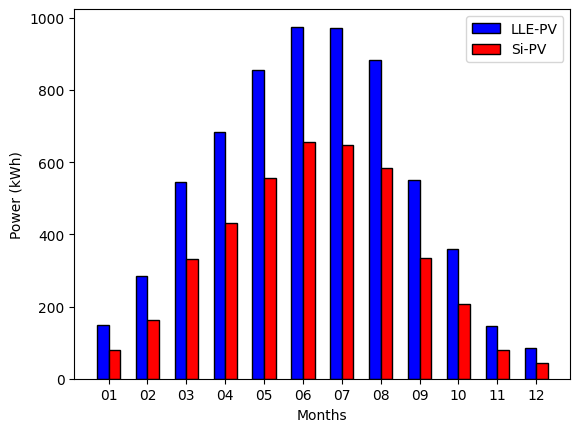

In [4]:
plt.bar(power_CFPV.index, power_CFPV, width = 0.3, color='blue', edgecolor = 'black', label='LLE-PV')
plt.bar(r1, power_si, width = 0.3, color='red', edgecolor = 'black', label='Si-PV')
plt.xticks([r + 0.15 for r in range(len(power_CFPV))],power_CFPV.index) 
plt.ylabel('Power (kWh)')
plt.xlabel('Months')
plt.legend()
plt.show()

In [5]:
mean_irradiance = irradiance.groupby(irradiance.index.strftime('%m')).max()

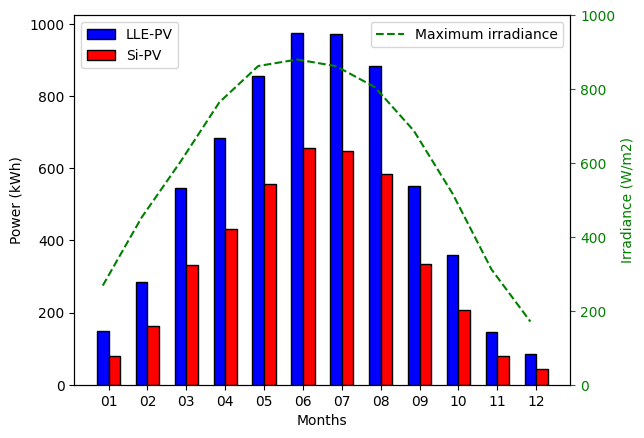

In [6]:

fig, ax1 = plt.subplots()
ax1.bar(power_CFPV.index, power_CFPV, width = 0.3, color='blue', edgecolor = 'black', label='LLE-PV')
ax1.bar(r1, power_si, width = 0.3, color='red', edgecolor = 'black', label='Si-PV')
plt.xticks([r + 0.15 for r in range(len(power_CFPV))],power_CFPV.index) 
ax1.set_yticks(range(0, 1001, 200))
ax1.set_ylabel('Power (kWh)')
ax1.set_xlabel('Months')
ax1.legend()
ax2 = ax1.twinx()
ax2.plot(mean_irradiance.index, mean_irradiance['GHI'], 'g--', label='Maximum irradiance')
ax2.set_ylabel('Irradiance (W/m2)', color='green')
ax2.tick_params('y', colors='green')
ax2.set_yticks(range(0, 1001, 200))


# Add legends for both plots
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

plt.show()


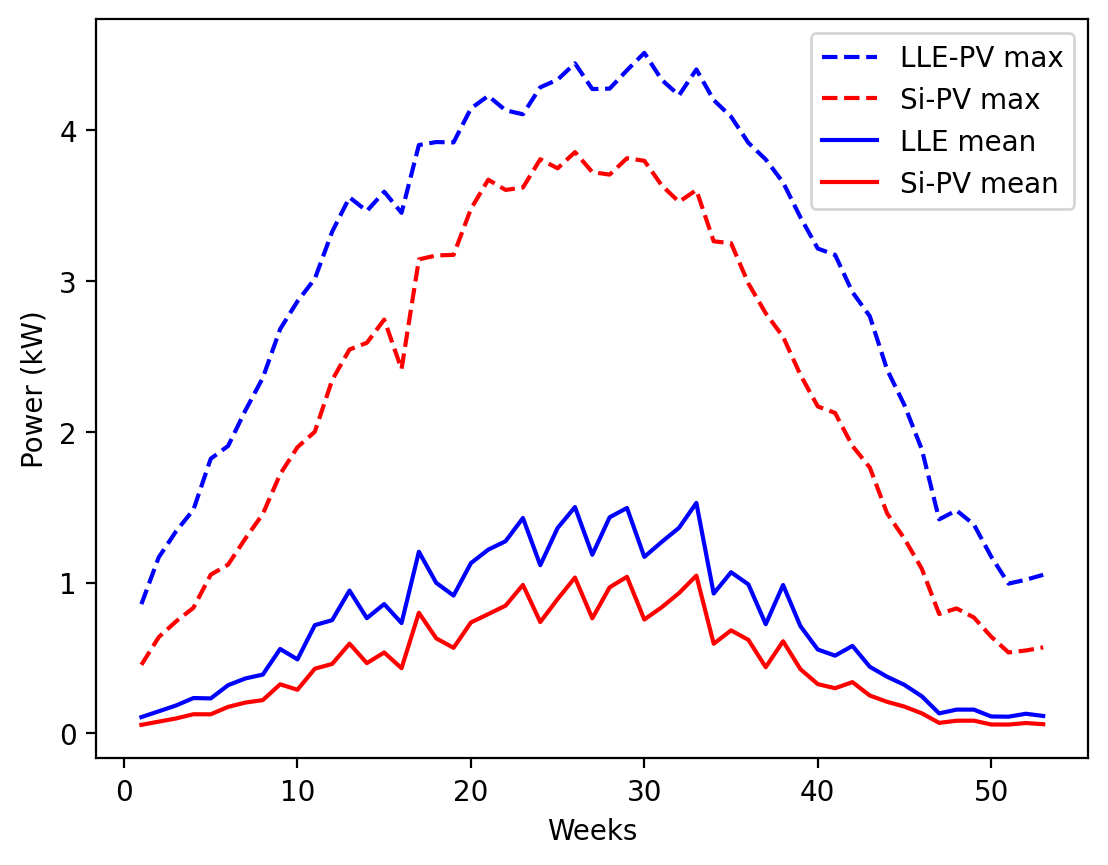

In [11]:
%config InlineBackend.figure_format = 'retina'  # This sets a higher DPI (e.g., for high-resolution displays)

power_CFPV_max= Total_PV['P_CFPV'].groupby(Total_PV.index.strftime('%Y-%U')).max()
power_CFPV_max = power_CFPV_max.drop(power_CFPV_max.index[-1])
power_si_max = Total_PV['P'].groupby(Total_PV.index.strftime('%Y-%U')).max()
power_si_max = power_si_max.drop(power_si_max.index[-1])
power_CFPV_mean = Total_PV['P_CFPV'].groupby(Total_PV.index.strftime('%Y-%U')).mean()
power_CFPV_mean = power_CFPV_mean.drop(power_CFPV_mean.index[-1])
power_si_mean = Total_PV['P'].groupby(Total_PV.index.strftime('%Y-%U')).mean()
power_si_mean = power_si_mean.drop(power_si_mean.index[-1])

fig, ax1 = plt.subplots()
ax1.plot(range(1,54), power_CFPV_max/1000, label='LLE-PV max', color='blue', linestyle='--')
ax1.plot(range(1,54), power_si_max/1000, label='Si-PV max', color='red', linestyle='--')
ax1.plot(range(1,54), power_CFPV_mean/1000, label='LLE mean', color='blue', linestyle='-')
ax1.plot(range(1,54), power_si_mean/1000, label='Si-PV mean', color='red', linestyle='-')

# ax2 = ax1.twinx()
# max_irradiance = irradiance.groupby(irradiance.index.strftime('%Y-%U')).max()
# max_irradiance = max_irradiance.drop(max_irradiance.index[-1])
# ax2.plot(range(1,54), max_irradiance['GHI'], 'g-', label='Maximum irradiance')
# ax2.set_ylabel('Irradiance (W/m2)', color='green')
# ax2.tick_params('y', colors='green')

ax1.set_ylabel('Power (kW)')
ax1.set_xlabel('Weeks')
ax1.legend()

# # Add legends for both plots
ax1.legend(loc='upper right')
# ax2.legend(loc='upper right')


In [8]:
mean_irradiance = irradiance.groupby(irradiance.index.strftime('%Y-%U')).max()

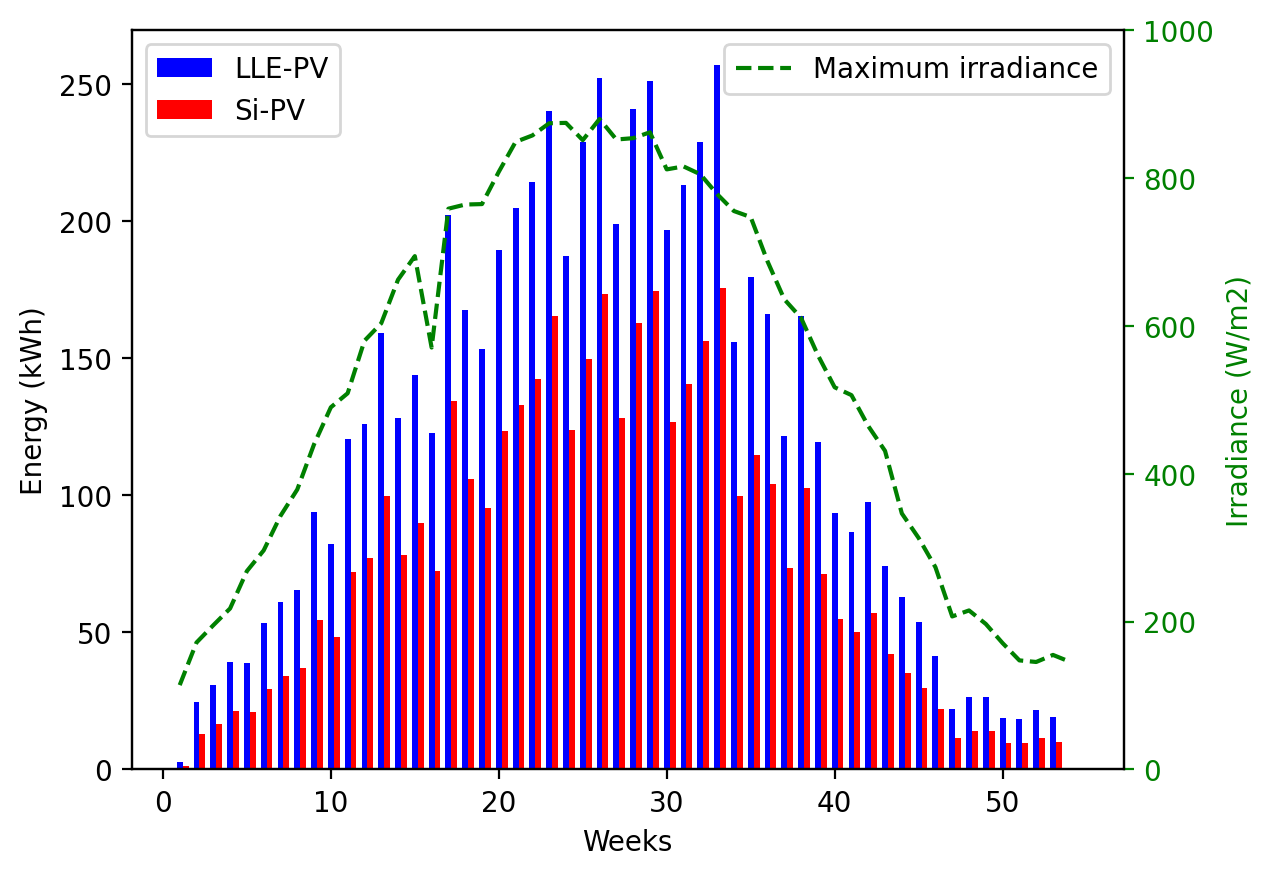

In [12]:
%config InlineBackend.figure_format = 'retina'  # This sets a higher DPI (e.g., for high-resolution displays)

fig, ax1 = plt.subplots()
ax1.bar(range(1,55), Total_PV['P_CFPV'].groupby(Total_PV.index.strftime('%Y-%U')).sum()/60000, width=0.35, label='LLE-PV', color='blue')
ax1.bar([week + 0.35 for week in range(1,55)], Total_PV['P'].groupby(Total_PV.index.strftime('%Y-%U')).sum()/60000, width=0.35, label='Si-PV', color='red')

ax1.set_ylabel('Energy (kWh)')
ax1.set_xlabel('Weeks')
ax1.legend(loc='upper left')

ax1.legend()
ax2 = ax1.twinx()
ax2.plot(range(1,55), mean_irradiance['GHI'], 'g--', label='Maximum irradiance')
ax2.set_ylabel('Irradiance (W/m2)', color='green')
ax2.tick_params('y', colors='green')
ax2.set_yticks(range(0, 1001, 200))


# Add legends for both plots
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

# # Add legends for both plots
plt.show()

In [10]:
combined

NameError: name 'combined' is not defined